# 進出場策略 (Entry & Exit Strategies)

## 看一下單一股票的進出場狀況

In [90]:
import ffn

%matplotlib inline

import pandas_datareader.data as web
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import requests
from bs4 import BeautifulSoup

from io import StringIO

## 讀取股價歷史資料

In [121]:
# 讀取從指定日期之後的股價資訊
df = web.DataReader("TSLA", 'yahoo', datetime(2016,8,1))

ImmediateDeprecationError: 
Yahoo Daily has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues


## 從 Nasdaq 讀取股價歷史資料

In [92]:
symbol = 'GOOG'.lower()
url_template = "https://www.nasdaq.com/symbol/{symbol}/historical"
url = url_template.format(symbol=symbol)

In [93]:
rs = requests.session()
r = rs.get(url)

In [94]:
soup = BeautifulSoup(r.text, 'lxml')
params = soup.select('#getFile input')

In [95]:
# 時間長短：5d, 1m, 3m, 6m, 1y, 18m, 2y, 3y, 4y, 5y, 6y, 7y, 8y, 9y, 10y
timeframe = '{timestr}|true|{symbol}'.format(timestr='18m', symbol=symbol.upper())

In [96]:
payload = {}
for tag in params:
    if tag['name'] != 'ctl00$quotes_content_left$submitString':
        payload[tag['name']] = tag['value']
    else:
        payload[tag['name']] = timeframe

In [97]:
r = rs.post(url, data=payload, verify=False)

In [98]:
r.text

'"date","close","volume","open","high","low"\r\n"16:00","1,037.98","1,211,208","1,036.98","1,043.24","1,026.74"\r\n"2018/04/16","1037.9800","1194144.0000","1037.0000","1043.2400","1026.7400"\r\n"2018/04/13","1029.2700","1175754.0000","1040.8800","1046.4200","1022.9800"\r\n"2018/04/12","1032.5100","1357599.0000","1025.0400","1040.6900","1021.4347"\r\n"2018/04/11","1019.9700","1476133.0000","1027.9900","1031.3641","1015.8700"\r\n"2018/04/10","1031.6400","1983510.0000","1026.4400","1036.2800","1011.3400"\r\n"2018/04/09","1015.4500","1738682.0000","1016.8000","1039.6000","1014.0800"\r\n"2018/04/06","1007.0400","1740896.0000","1020.0000","1031.4200","1003.0300"\r\n"2018/04/05","1027.8100","1345681.0000","1041.3300","1042.7900","1020.1311"\r\n"2018/04/04","1025.1400","2464418.0000","993.4100","1028.7175","993.0000"\r\n"2018/04/03","1013.4100","2271858.0000","1013.9100","1020.9900","994.0700"\r\n"2018/04/02","1006.4700","2679214.0000","1022.8200","1034.8000","990.3700"\r\n"2018/03/29","1031.7

In [99]:
df = pd.read_csv(StringIO(r.text))

In [100]:
df = df[df.date!='16:00']

In [101]:
for column in df:
    if column!='date':
        df[column] = pd.to_numeric(df[column])

In [102]:
df.date = pd.to_datetime(df.date)

In [103]:
df.columns = map(str.capitalize, df.columns)

In [104]:
df = df.set_index('Date').sort_index()

In [105]:
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2016-10-17,779.96,1091524.0,779.80,785.85,777.500
2016-10-18,795.26,2046338.0,787.85,801.61,785.565
2016-10-19,801.56,1762990.0,798.86,804.63,797.635
2016-10-20,796.97,1755546.0,803.30,803.97,796.030
2016-10-21,799.37,1262042.0,795.00,799.50,794.000


In [106]:
# 計算均線
df['20d'] = pd.Series.rolling(df['Close'], window=20).mean()
df['60d'] = pd.Series.rolling(df['Close'], window=60).mean()

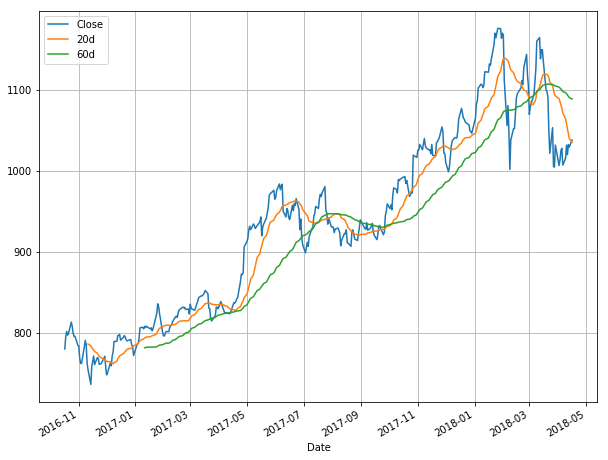

In [107]:
df[['Close','20d','60d']].plot(grid=True, figsize=(10,8))

In [108]:
# Donchian Channel
df['20d_high'] = pd.Series.rolling(df['Close'], window=20).max()
df['10d_low'] = pd.Series.rolling(df['Close'], window=10).min()

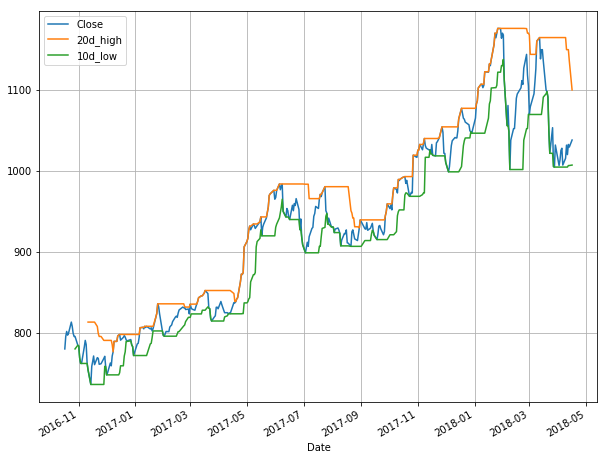

In [109]:
df[['Close','20d_high','10d_low']].plot(grid=True, figsize=(10,8))

## 策略

In [110]:
def breakout(df):
    # Donchian Channel
    df['20d_high'] = pd.Series.rolling(df['Close'], window=20).max()
    df['10d_low'] = pd.Series.rolling(df['Close'], window=10).min()

    has_position = False
    df['signals'] = np.zeros(np.size(df['Close']))
    for t in range(2, df['signals'].size):
        if df['Close'][t] > df['20d_high'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif df['Close'][t] < df['10d_low'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()

    df[['signals', 'positions']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (10, 8))

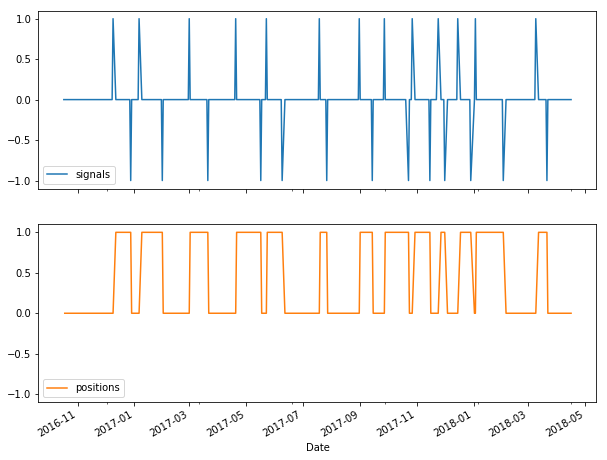

In [112]:
breakout(df)

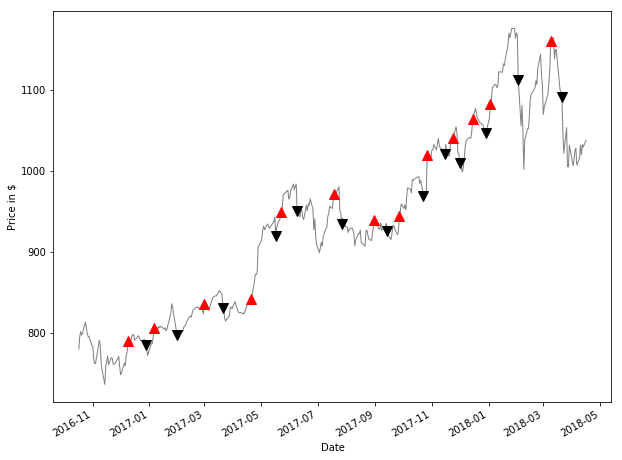

In [113]:
fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')
    
df['Close'].plot(ax=ax1, color='gray', lw=1., figsize=(10,8))

# Plot the "buy" trades
ax1.plot(df.loc[df.signals == 1].index,df['Close'][df.signals == 1],'^', markersize=10, color='r')

# Plot the "sell" trades
ax1.plot(df.loc[df.signals == -1].index, df['Close'][df.signals == -1], 'v', markersize=10, color='k')

## 計算Sharpe Ratio

In [114]:
dailyRet = df['Close'].pct_change()

In [115]:
#假設無風險利率為 4%
#假設一年有252個交易日
excessRet = (dailyRet - 0.04/252)[df['positions']==1.0]

sharpeRatio = np.sqrt(252.0)*np.mean(excessRet)/np.std(excessRet)

In [116]:
sharpeRatio

-0.5563231430282072

## 計算MaxDD跟MaxDDD

In [117]:
cumRet = np.cumprod(1 + excessRet)

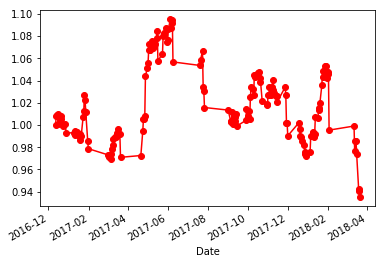

In [118]:
cumRet.plot(style='ro-')

In [119]:
def DrawDownAnalysis(cumRet):
    dd_series = ffn.core.to_drawdown_series(cumRet)
    dd_details = ffn.core.drawdown_details(dd_series)
    return dd_details['drawdown'].min(), dd_details['days'].max()

In [120]:
DrawDownAnalysis(cumRet)

(-0.1463554876264015, 288)